In [1]:
# imports
import os
from types import SimpleNamespace

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import zscore
import pandas as pd
import csv
import matplotlib.colors as mcolors


import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

In [106]:
metrics={}

### Load track2p folder and suite2p datasets

In [148]:
#load all the datasets
def find_t2p_directories(parent_directory):
    # List all items in the parent directory
    items = os.listdir(parent_directory)
    # Filter the list to include only directories that start with "t2p"
    t2p_directories = [item for item in items if item.startswith('t2p') and os.path.isdir(os.path.join(parent_directory, item))]
    return t2p_directories

parent_directory = '/Users/manonmantez/Desktop/jm038/' 
t2p_dirs = find_t2p_directories(parent_directory)
print(t2p_dirs)

['t2p_aff_chan0_all_', 't2p_P8_13', 't2p_P8_14', 't2p_P8_12', 't2p_P8_11_14', 't2p_P8_10_14', 't2p_P8_13_14', 't2p_P8_14_chan0', 't2p_P8_9', 't2p_P8_12_chan0', 't2p_P8_10_chan0', 't2p_P8_12_14', 't2p_rigid_chan1_all_', 't2p_P8_10', 't2p_P8_11', 't2p_P8_11_chan0', 't2p_P8_9_chan0', 't2p_P8_9_14', 't2p_P8_13_chan0', 't2p_affine_chan1_all_']


In [240]:
path = 't2p_rigid_chan1_all_'
print(path)
plane = 'plane0' # which plane to process (the example dataset is single-plane)
option= 1 #1: Registration done of all days, 2 : Registration done of two days , 3 : Registration done of three days
print(option)
days = ['P8', 'P9', 'P10' ,'P11', 'P12','P13','P14']

t2p_rigid_chan1_all_
1


In [241]:
if option == 2 :
    second_day= 'P9' # change this !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    if second_day in days:
        index_of_second_day = days.index(second_day)
        print(index_of_second_day)

In [150]:
if option == 3 :
    second_day= 'P13' # change this
    third_day= 'P14' # change this
    if third_day in days:
        index_of_second_day = days.index(second_day)
        index_of_third_day = days.index(third_day)
        print(index_of_second_day)
        print(index_of_third_day)

5
6


In [242]:
t2p_save_path = os.path.join(parent_directory, path)
print(t2p_save_path)

/Users/manonmantez/Desktop/jm038/t2p_rigid_chan1_all_


In [243]:
# np.load() the match matrix (plane0_match_mat.npy)
t2p_match_mat = np.load(os.path.join(t2p_save_path,  'track2p',f'{plane}_match_mat.npy'), allow_pickle=True)
# np.load() settings (this contains suite2p paths etc.) (track_ops.npy)
track_ops_dict = np.load(os.path.join(t2p_save_path, 'track2p', 'track_ops.npy'), allow_pickle=True).item()
track_ops = SimpleNamespace(**track_ops_dict) # create dummy object from the track_ops dictionary
print(track_ops.reg_chan)
print(track_ops.transform_type)

1
rigid


In [244]:
print('Datasets used for t2p:\n')
for ds_path in track_ops.all_ds_path:
    print(ds_path)

print('\nMatch matrix shape:')
print(t2p_match_mat.shape)

Datasets used for t2p:

/Users/manonmantez/Desktop/jm038/2023-04-30_a
/Users/manonmantez/Desktop/jm038/2023-05-01_a
/Users/manonmantez/Desktop/jm038/2023-05-02_a
/Users/manonmantez/Desktop/jm038/2023-05-03_a
/Users/manonmantez/Desktop/jm038/2023-05-04_a
/Users/manonmantez/Desktop/jm038/2023-05-05_a
/Users/manonmantez/Desktop/jm038/2023-05-06_a

Match matrix shape:
(2190, 7)


## Above is the output of the algorithm, now generate ground truth
### Generate grid

In [221]:
# load the suite2p output of the first dataset
s2p_path = os.path.join(track_ops.all_ds_path[0], 'suite2p', plane)

# load the ops and stat
ops_first = np.load(os.path.join(s2p_path, 'ops.npy'), allow_pickle=True).item()
stat_first = np.load(os.path.join(s2p_path, 'stat.npy'), allow_pickle=True)
iscell_first = np.load(os.path.join(s2p_path, 'iscell.npy'), allow_pickle=True)
s2p_inds = np.arange(len(stat_first))

# filter stat based on the track2p probability
print(f'Filtering stat based on the track2p probability (iscell_thr={track_ops.iscell_thr})')
s2p_inds_iscell = s2p_inds[iscell_first[:, 0] > track_ops.iscell_thr]
stat_first_iscell = stat_first[iscell_first[:, 0] > track_ops.iscell_thr]
print(f'Filtered stat from {len(stat_first)} to {len(stat_first_iscell)} cells')



Filtering stat based on the track2p probability (iscell_thr=0.5)
Filtered stat from 3587 to 2190 cells


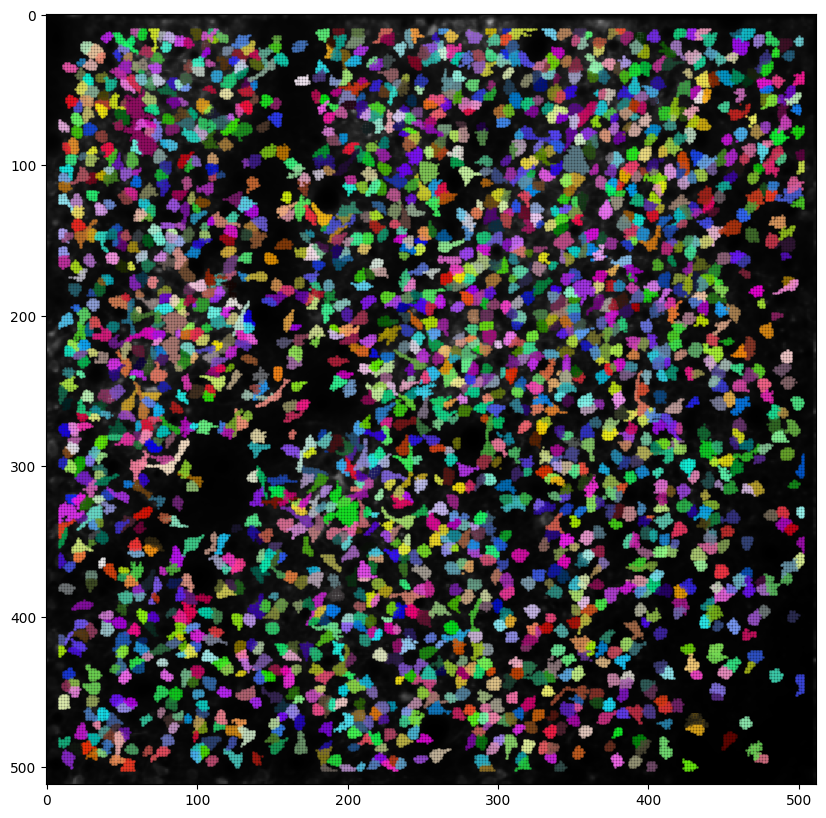

In [222]:
# now plot the fov with contours
plt.figure(figsize=(10, 10))
plt.imshow(ops_first['meanImg'], cmap='gray')
for i in range(len(stat_first_iscell)):
    # get random color 
    color = np.random.rand(3)
    plt.scatter(stat_first_iscell[i]['xpix'], stat_first_iscell[i]['ypix'], s=1, color=color, alpha=0.5)

(-0.5, 511.5, 511.5, -0.5)

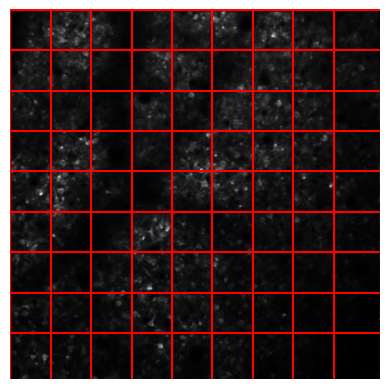

In [223]:
# now make a 8x8 grid on the image
n_grid = 9
grid_x = np.arange(0, ops_first['meanImg'].shape[1], ops_first['meanImg'].shape[1] // n_grid)
grid_y = np.arange(0, ops_first['meanImg'].shape[0], ops_first['meanImg'].shape[0] // n_grid)

plt.imshow(ops_first['meanImg'], cmap='gray')
for i in range(n_grid):
    plt.axvline(grid_x[i], color='r')
    plt.axhline(grid_y[i], color='r')

plt.axis('off')

In [224]:
# now for each grid cross get the nearest cell (except for 0 and 512 pixels)
all_cell_med = []

# get all cell medians from stat
for i in range(len(stat_first_iscell)):
    all_cell_med.append(stat_first_iscell[i]['med'])
    

In [225]:
# compute coordinates of the grid crosses
grid_crosses = []
for i in range(1, n_grid):
    for j in range(1, n_grid):
        grid_crosses.append((grid_x[i], grid_y[j]))

grid_crosses

[(56, 56),
 (56, 112),
 (56, 168),
 (56, 224),
 (56, 280),
 (56, 336),
 (56, 392),
 (56, 448),
 (112, 56),
 (112, 112),
 (112, 168),
 (112, 224),
 (112, 280),
 (112, 336),
 (112, 392),
 (112, 448),
 (168, 56),
 (168, 112),
 (168, 168),
 (168, 224),
 (168, 280),
 (168, 336),
 (168, 392),
 (168, 448),
 (224, 56),
 (224, 112),
 (224, 168),
 (224, 224),
 (224, 280),
 (224, 336),
 (224, 392),
 (224, 448),
 (280, 56),
 (280, 112),
 (280, 168),
 (280, 224),
 (280, 280),
 (280, 336),
 (280, 392),
 (280, 448),
 (336, 56),
 (336, 112),
 (336, 168),
 (336, 224),
 (336, 280),
 (336, 336),
 (336, 392),
 (336, 448),
 (392, 56),
 (392, 112),
 (392, 168),
 (392, 224),
 (392, 280),
 (392, 336),
 (392, 392),
 (392, 448),
 (448, 56),
 (448, 112),
 (448, 168),
 (448, 224),
 (448, 280),
 (448, 336),
 (448, 392),
 (448, 448)]

(-0.5, 511.5, 511.5, -0.5)

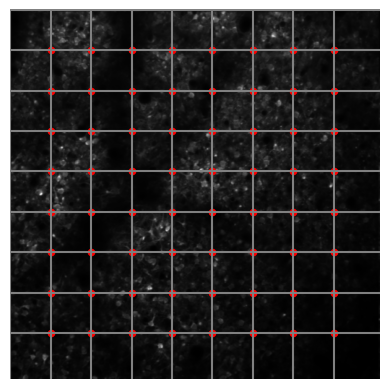

In [226]:
plt.imshow(ops_first['meanImg'], cmap='gray')
for i in range(n_grid):
    plt.axvline(grid_x[i], color='gray')
    plt.axhline(grid_y[i], color='gray')
for cross in grid_crosses:
    plt.scatter(cross[0], cross[1], s=20, color='r')

plt.axis('off')


In [227]:
# compute distances between each cell and each grid cross
distances = np.zeros((len(stat_first_iscell), len(grid_crosses)))
for i, cell_med in enumerate(all_cell_med):
    for j, cross in enumerate(grid_crosses):
        distances[i, j] = np.sqrt((cell_med[0] - cross[0])**2 + (cell_med[1] - cross[1])**2)

In [228]:
# now get the nearest cell for each grid cross
nearest_cells = np.argmin(distances, axis=0)
nearest_cells

array([1494, 1140, 1449,  265, 1146,  924,  177, 2168, 1172,  913, 1927,
       1002, 1454,  237,  505, 1722, 1304, 1943, 1190, 1987,  429, 1490,
       2153,  364,  139, 1320, 1975,  533,  445, 1506, 1213,  880,  111,
       1217, 1520,  279, 1831, 1698,  582, 1829,  811, 1678,   79, 1293,
       1672, 1382, 1988,  980,   66, 1083,  814,   68, 1992,  856, 1679,
       1424, 1612,  984, 1258,  368,  610,  721, 1085, 2055])

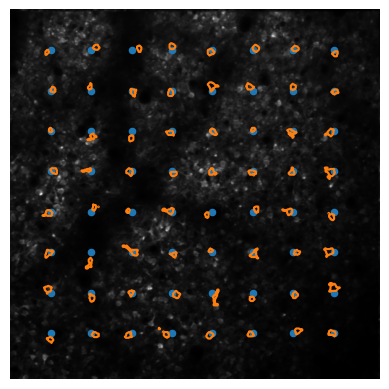

In [229]:
plt.imshow(ops_first['meanImg'], cmap='gray')

for cross in grid_crosses:
    plt.scatter(cross[0], cross[1], s=20, color='C0')

plt.axis('off')

for i, cell in enumerate(nearest_cells):
    roi = np.zeros_like(ops_first['meanImg'])
    roi[stat_first_iscell[cell]['ypix'], stat_first_iscell[cell]['xpix']] = 1
    plt.contour(roi, levels=[0.5], colors='C1')


In [230]:
# now get the original indices
original_indices = s2p_inds_iscell[nearest_cells]
print('Now open suite2p and try to manually track cells:')
[print(f'{original_indices[i]}') for i in range(len(original_indices))]

Now open suite2p and try to manually track cells:
1779
1254
1708
267
1263
985
179
3480
1301
973
2719
1083
1717
239
511
2212
1480
2751
1326
2874
432
1773
3425
366
141
1506
2840
540
448
1796
1356
935
113
1362
1817
281
2450
2166
592
2447
853
2124
81
1464
2115
1601
2875
1059
67
1181
856
70
2881
905
2126
1672
1990
1065
1419
370
622
746
1183
3060


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

(-0.5, 511.5, 511.5, -0.5)

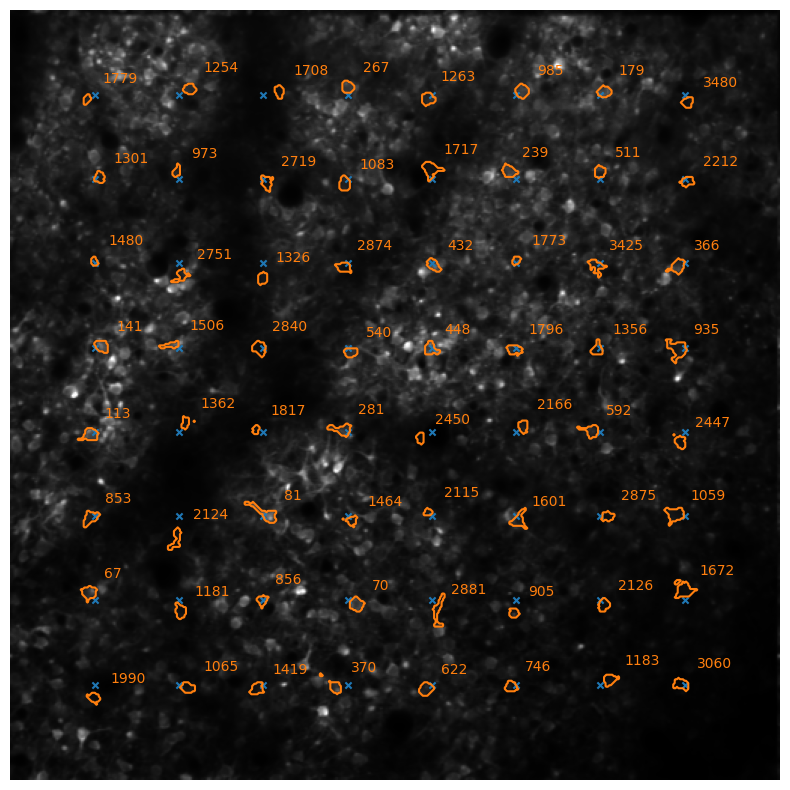

In [231]:
# make the same plot as above but with numbers labeled next to the roi
plt.figure(figsize=(10, 10))
# clip based on 99.99 percentile
img = ops_first['meanImg'].copy()
img[img > np.percentile(img, 99.99)] = np.percentile(img, 99.99)
plt.imshow(img, cmap='gray')

for i, cell in enumerate(nearest_cells):
    roi = np.zeros_like(ops_first['meanImg'])
    roi[stat_first_iscell[cell]['ypix'], stat_first_iscell[cell]['xpix']] = 1
    plt.contour(roi, levels=[0.5], colors='C1')
    plt.text(stat_first_iscell[cell]['med'][1]+10, stat_first_iscell[cell]['med'][0]-10, f'{original_indices[i]}', color='C1')
    plt.scatter(grid_crosses[i][0], grid_crosses[i][1], s=20, color='C0', marker='x')

plt.axis('off')

### Getting real suite2p indexes to compare it to

In [245]:
def function(path, plane):

    track_ops_dict = np.load(os.path.join(path, "track2p", "track_ops.npy"), allow_pickle=True).item()
    track_ops = SimpleNamespace(**track_ops_dict)
    t2p_match_mat = np.load(os.path.join(path,"track2p" ,f"{plane}_match_mat.npy"), allow_pickle=True)
    t2p_match_mat_allday = t2p_match_mat
    
    if track_ops.iscell_thr is not None:
        true_indices= np.empty((len(t2p_match_mat), len(track_ops.all_ds_path)), dtype=object)
        
    for j in range(len(t2p_match_mat)):
        for (i, ds_path) in enumerate(track_ops.all_ds_path):
            iscell = np.load(os.path.join(ds_path, 'suite2p', plane, 'iscell.npy'), allow_pickle=True)
            if track_ops.iscell_thr is not None:
                s2p_indexes= np.where(iscell[:,1]>track_ops.iscell_thr)[0]
                t2p_index=t2p_match_mat[j,i]

                if t2p_index is None:
                    true_index = None
                else:
                    true_index=s2p_indexes[t2p_index]

                true_indices[j, i] = true_index
            else:
                pass
    if track_ops.iscell_thr is not None:        
        np.save(os.path.join(path, "true_indices.npy"), true_indices)
        print("saved")
    else:
        print("not in locals")
        
function(t2p_save_path, plane)  

indices_npy= np.load(os.path.join(t2p_save_path,"true_indices.npy"), allow_pickle=True)
print(indices_npy)
print(indices_npy.shape)

saved
[[0 2 36 ... None None None]
 [1 60 13 ... 14 47 55]
 [2 16 None ... None None None]
 ...
 [None None None ... None None None]
 [3581 2320 930 ... None None None]
 [None None None ... None None None]]
(2190, 7)


In [246]:
np.sort(original_indices)

array([  67,   70,   81,  113,  141,  179,  239,  267,  281,  366,  370,
        432,  448,  511,  540,  592,  622,  746,  853,  856,  905,  935,
        973,  985, 1059, 1065, 1083, 1181, 1183, 1254, 1263, 1301, 1326,
       1356, 1362, 1419, 1464, 1480, 1506, 1601, 1672, 1708, 1717, 1773,
       1779, 1796, 1817, 1990, 2115, 2124, 2126, 2166, 2212, 2447, 2450,
       2719, 2751, 2840, 2874, 2875, 2881, 3060, 3425, 3480])

In [247]:
# index rows for cells where the first row is in original_indices
all_s2p_idxs = []
for idx in np.sort(original_indices):
    idx_row = np.where(indices_npy[:,0]==idx)

    if len(idx_row[0]) == 0:
        s2p_idxs = [None]*len(track_ops.all_ds_path)
        #print('here')

    else:
        s2p_idxs = indices_npy[idx_row]
    all_s2p_idxs.append(s2p_idxs[0])

all_s2p_idxs = np.array(all_s2p_idxs)

#print(all_s2p_idxs.dtype)
print(all_s2p_idxs)

[array([67, 38, 15, 1017, None, None, None], dtype=object)
 array([70, 193, 224, None, None, None, None], dtype=object)
 array([81, 187, 65, 678, None, None, None], dtype=object)
 array([113, 67, 170, 882, 104, 69, 98], dtype=object)
 array([141, 140, 553, 687, 175, 283, 681], dtype=object)
 array([179, 521, 823, 889, None, None, None], dtype=object)
 array([239, 154, 417, 16, 52, 94, 30], dtype=object)
 array([267, 313, 38, None, None, None, None], dtype=object)
 array([281, 953, 294, 483, 1330, None, None], dtype=object)
 array([366, 118, 150, 528, 739, 359, 5], dtype=object)
 array([370, 786, 1271, None, None, None, None], dtype=object)
 array([432, 538, 370, 612, 188, 722, 510], dtype=object)
 array([448, 3060, None, None, None, None, None], dtype=object)
 array([511, 874, 880, None, None, None, None], dtype=object) None None
 array([622, 434, 1141, 820, 530, 598, 1332], dtype=object)
 array([746, 1285, None, None, None, None, None], dtype=object)
 array([853, 1058, 554, 205, None,

/var/folders/95/8rmbkst12z960tdjyz8xj_h40000gn/T/ipykernel_57375/441369794.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_s2p_idxs = np.array(all_s2p_idxs)


### Load 'ground truth' (csv table)

In [248]:
manual_matches = np.genfromtxt(os.path.join(parent_directory, 'manual_matches.csv'), delimiter=';', skip_header=1 )
manual_matches = np.where(np.isnan(manual_matches), None, manual_matches)
manual_matches = [[int(x) if x is not None else None for x in row] for row in manual_matches]
manual_matches

[[67, 38, 15, 169, None, None, None],
 [70, 193, 224, 119, 120, 199, 76],
 [81, 187, 65, 50, 21, 129, 11],
 [113, 67, 170, 46, 487, 243, 464],
 [141, 140, 553, 713, 1116, 10, 12],
 [179, 521, 823, 230, None, None, None],
 [239, 154, 417, 16, 52, 94, 30],
 [267, 313, 38, None, None, None, None],
 [281, 953, 294, 208, 26, 80, 84],
 [366, 118, 150, 36, 19, 26, 218],
 [370, 786, 1271, 842, 421, 472, 488],
 [432, 538, 370, 612, 188, 722, 510],
 [448, 3060, None, None, None, None, None],
 [511, 874, 880, None, None, None, None],
 [540, None, None, None, None, None, None],
 [592, None, None, None, None, None, None],
 [622, 434, 1141, 888, 1133, 1789, None],
 [746, 1285, 1446, None, None, None, None],
 [853, 1058, 554, 1234, 1099, 1158, 588],
 [856, 1163, 1085, 1056, 441, None, None],
 [905, None, None, None, None, None, None],
 [935, 547, 1133, 723, 130, 871, 624],
 [973, None, None, None, None, None, None],
 [985, 669, None, None, None, None, None],
 [1059, None, None, None, None, None, None

In [249]:
for i in range(len(manual_matches)):
    # Vérifier si tous les éléments sauf le premier sont "None"
    if all(x == None for x in manual_matches[i][1:]):
        manual_matches[i] = None

In [250]:
for i in range(len(manual_matches)):
    # print the rows
    print(f'track2p:     {all_s2p_idxs[i]}')
    print(f'manual:      {manual_matches[i]}')
    print('')

track2p:     [67 38 15 1017 None None None]
manual:      [67, 38, 15, 169, None, None, None]

track2p:     [70 193 224 None None None None]
manual:      [70, 193, 224, 119, 120, 199, 76]

track2p:     [81 187 65 678 None None None]
manual:      [81, 187, 65, 50, 21, 129, 11]

track2p:     [113 67 170 882 104 69 98]
manual:      [113, 67, 170, 46, 487, 243, 464]

track2p:     [141 140 553 687 175 283 681]
manual:      [141, 140, 553, 713, 1116, 10, 12]

track2p:     [179 521 823 889 None None None]
manual:      [179, 521, 823, 230, None, None, None]

track2p:     [239 154 417 16 52 94 30]
manual:      [239, 154, 417, 16, 52, 94, 30]

track2p:     [267 313 38 None None None None]
manual:      [267, 313, 38, None, None, None, None]

track2p:     [281 953 294 483 1330 None None]
manual:      [281, 953, 294, 208, 26, 80, 84]

track2p:     [366 118 150 528 739 359 5]
manual:      [366, 118, 150, 36, 19, 26, 218]

track2p:     [370 786 1271 None None None None]
manual:      [370, 786, 1271, 8

In [251]:
def compute_metrics_all_days(all_s2p_idxs, manual_matches):

    all_s2p_idxs_all_days = all_s2p_idxs.copy()
    manual_matches_all_days = manual_matches.copy()

    #IoU=1
    for i in range(len(manual_matches)):
        if all_s2p_idxs_all_days[i] is not None:
            if any(x is None for x in all_s2p_idxs_all_days[i]):
                all_s2p_idxs_all_days[i] = None
        if manual_matches_all_days[i] is not None:
            if any(x is None for x in manual_matches_all_days[i]):
                manual_matches_all_days[i] = None


       #print(f'track2p:     {all_s2p_idxs[i]}')
       # print(f'manual:      {manual_matches[i]}')
       #print('')
        print(f'track2p:     {all_s2p_idxs_all_days[i]}')
        print(f'manual:      {manual_matches_all_days[i]}')
       # print('')


    count_FP=0
    count_TP=0
    count_FN=0
    count_IS=0
    count_TN=0

    nb_days= len(track_ops.all_ds_path)

    for i in range(len(manual_matches_all_days)):
        if all_s2p_idxs_all_days[i] is None and manual_matches_all_days[i] is None:
             count_TN +=1
        # if track2p detected on all days 
        elif all_s2p_idxs_all_days[i] is None and manual_matches_all_days[i] is not None:
                count_FN +=1
                print('FN')
                print( all_s2p_idxs_all_days[i] )
                print( manual_matches_all_days[i] )
        elif all_s2p_idxs_all_days[i] is not None and manual_matches_all_days[i] is None:
                count_FP +=1
                print('FP')
                print( all_s2p_idxs_all_days[i] )
                print( manual_matches_all_days[i] )
        elif all_s2p_idxs_all_days[i] is not None and manual_matches_all_days[i] is not None:
            if any((x!=y) for x, y in zip(all_s2p_idxs_all_days[i], manual_matches_all_days[i])):
                    count_IS +=1
                    print('FP')
                    print( all_s2p_idxs_all_days[i] )
                    print( manual_matches_all_days[i] )
            else:
                    count_TP +=1

    print(f'FP: {count_FP}')
    print(f'TP: {count_TP}')
    print(f'FN: {count_FN}')
    print(f'IS: {count_IS}')

    TP_rate= count_TP/len(manual_matches_all_days)
    TN_rate= count_TN/len(manual_matches_all_days)
    FP_rate= count_FP/len(manual_matches_all_days)
    FN_rate= count_FN/len(manual_matches_all_days)
    IS_rate= count_IS/len(manual_matches_all_days)


    total_rate= TP_rate + TN_rate + FP_rate + FN_rate + IS_rate
    print(f'Sum of rates: {total_rate:.2f}')

    precision = count_TP/(count_TP+count_FP+count_IS)
    recall = count_TP/(count_TP+count_FN)
    f1 = 2*(precision*recall)/(precision+recall)
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')


    filename= os.path.join(t2p_save_path,'metrics_tracking_all_days.csv')
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file ,delimiter=";")
        writer.writerow(['TP', TP_rate])
        writer.writerow(['TN', TN_rate])
        writer.writerow(['FP', FP_rate])
        writer.writerow(['FN', FN_rate])
        writer.writerow(['IS', IS_rate])
        writer.writerow(['Precision', round(precision,2)])
        writer.writerow(['Recall', round(recall,2)])
        writer.writerow(['F1', round(f1,2)])
    print(f"CSV file '{filename}' created successfully.")
        

In [252]:
compute_metrics_all_days(all_s2p_idxs, manual_matches)

track2p:     None
manual:      None
track2p:     None
manual:      [70, 193, 224, 119, 120, 199, 76]
track2p:     None
manual:      [81, 187, 65, 50, 21, 129, 11]
track2p:     [113 67 170 882 104 69 98]
manual:      [113, 67, 170, 46, 487, 243, 464]
track2p:     [141 140 553 687 175 283 681]
manual:      [141, 140, 553, 713, 1116, 10, 12]
track2p:     None
manual:      None
track2p:     [239 154 417 16 52 94 30]
manual:      [239, 154, 417, 16, 52, 94, 30]
track2p:     None
manual:      None
track2p:     None
manual:      [281, 953, 294, 208, 26, 80, 84]
track2p:     [366 118 150 528 739 359 5]
manual:      [366, 118, 150, 36, 19, 26, 218]
track2p:     None
manual:      [370, 786, 1271, 842, 421, 472, 488]
track2p:     [432 538 370 612 188 722 510]
manual:      [432, 538, 370, 612, 188, 722, 510]
track2p:     None
manual:      None
track2p:     None
manual:      None
track2p:     None
manual:      None
track2p:     None
manual:      None
track2p:     [622 434 1141 820 530 598 1332]
man

### functions to get metrics (FP,FN,F1...)

In [120]:
def calculate_metrics_pairs(manual_matches_elements,all_s2p_idxs_elements):
    
    TP_indexes=[]
    FP_indexes=[]
    TN_indexes=[]
    FN_indexes=[]
    IS_indexes=[]

    for i in range(len(manual_matches_elements)):

        if  all_s2p_idxs_elements[i][1] == manual_matches_elements[i][1] and all_s2p_idxs_elements[i][1] is not None:
            TP_indexes.append(i)

        elif all_s2p_idxs_elements[i][1] == manual_matches_elements[i][1] and all_s2p_idxs_elements[i][1] is None: 
            TN_indexes.append(i)
    
        elif manual_matches_elements[i][1] is None and all_s2p_idxs_elements[i][1] is not None:
            FP_indexes.append(i)
    
        elif all_s2p_idxs_elements[i][1] is None and manual_matches_elements[i][1] is not None:
            FN_indexes.append(i)

        elif all_s2p_idxs_elements[i][1] != manual_matches_elements[i][1] :
            IS_indexes.append(i)
            #FP_indexes.append(i)

    TP_rate= len(TP_indexes)/len(manual_matches_elements)
    TN_rate= len(TN_indexes)/len(manual_matches_elements)
    FP_rate= len(FP_indexes)/len(manual_matches_elements)
    FN_rate= len(FN_indexes)/len(manual_matches_elements)
    IS_rate= len(IS_indexes)/len(manual_matches_elements)


    print(f'TP: {len(TP_indexes)}   {TP_rate:.2f} \n')
    print(f'TN: {len(TN_indexes)}   {TN_rate:.2f} \n')
    print(f'FP: {len(FP_indexes)}   {FP_rate:.2f} \n')
    print(f'FN: {len(FN_indexes)}   {FN_rate:.2f} \n')
    print(f'IS: {len(IS_indexes)}   {IS_rate:.2f} \n')

    correctly_assign_link_rate = TP_rate + TN_rate
    incorrect_assign_link_rate = FP_rate + FN_rate + IS_rate

    print(f'correctly_assign_link_rate: {correctly_assign_link_rate:.2f}')
    print(f'incorrect_assign_link_rate: {incorrect_assign_link_rate:.2f}')

    total_rate= TP_rate + TN_rate + FP_rate + FN_rate + IS_rate
    print(f'Sum of rates: {total_rate:.2f}')

    precision= len(TP_indexes)/(len(TP_indexes) + (len(FP_indexes)+ len(IS_indexes)))
    recall= len(TP_indexes)/(len(TP_indexes) + len(FN_indexes))
    f1_score= (2*(precision*recall))/(precision+recall)

    return TP_rate, TN_rate, FP_rate, FN_rate, IS_rate, correctly_assign_link_rate, incorrect_assign_link_rate, precision, recall, f1_score



In [121]:
def write_metrics_to_csv(TP_rate_all_days, TN_rate_all_days, FP_rate_all_days, FN_rate_all_days, IS_rate_all_days,correctly_assign_link_rate_all_days, incorrect_assign_link_rate_all_days, precision_all_days, recall_all_days, f1_score_all_days, option):
        
    if option ==1 :
        row_names = ['TP_rate', 'TN_rate', 'FP_rate', 'FN_rate', 'IS_rate', 'correctly_assign_link_rate', 'incorrect_assign_link_rate', 'precision', 'recall', 'f1_score']
        column_names = ['P9', 'P10', 'P11', 'P12', 'P13', 'P14']

                        # Créer une liste de listes pour les données
        data = [
                TP_rate_all_days,
                TN_rate_all_days,
                FP_rate_all_days,
                FN_rate_all_days,
                IS_rate_all_days,
                correctly_assign_link_rate_all_days,
                incorrect_assign_link_rate_all_days,
                precision_all_days,
                recall_all_days,
                f1_score_all_days
                ]
            

            # Ajouter les noms des lignes
        data_with_row_names = [[row_names[i]] + [round(value, 2) for value in data[i]] for i in range(len(row_names))]

            
        filename= os.path.join(t2p_save_path,'metrics.csv')
            # Écrire les données dans un fichier CSV
        with open(filename, 'w', newline='') as file:
                writer = csv.writer(file, delimiter=';')
                writer.writerow([''] + column_names)  # Écrire les noms des colonnes
                writer.writerows(data_with_row_names)  # Écrire les données avec les noms des lignes

            
        print(f"CSV file '{filename}' created successfully.")
    
    if option ==2: 
                
        row_names = ['TP_rate', 'TN_rate', 'FP_rate', 'FN_rate', 'IS_rate', 'correctly_assign_link_rate', 'incorrect_assign_link_rate', 'precision', 'recall', 'f1_score']
        column_names = [days[index_of_second_day]]

                        # Créer une liste de listes pour les données
        data = [
                TP_rate_all_days,
                TN_rate_all_days,
                FP_rate_all_days,
                FN_rate_all_days,
                IS_rate_all_days,
                correctly_assign_link_rate_all_days,
                incorrect_assign_link_rate_all_days,
                precision_all_days,
                recall_all_days,
                f1_score_all_days
                ]
            
                # Ajouter les noms des lignes
        data_with_row_names = [[row_names[i]] + [round(value, 2) for value in data[i]] for i in range(len(row_names))]

        filename= os.path.join(t2p_save_path,'metrics.csv')
                # Écrire les données dans un fichier CSV
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file, delimiter=';')
            writer.writerow([''] + column_names)  # Écrire les noms des colonnes
            writer.writerows(data_with_row_names)  # Écrire les données avec les noms des lignes
        print(f"CSV file '{filename}' created successfully.")

    if option ==3:
         
        row_names = ['TP_rate', 'TN_rate', 'FP_rate', 'FN_rate', 'IS_rate', 'correctly_assign_link_rate', 'incorrect_assign_link_rate', 'precision', 'recall', 'f1_score']
        column_names = [days[index_of_second_day], days[index_of_third_day]]

                        # Créer une liste de listes pour les données
        data = [
                TP_rate_all_days,
                TN_rate_all_days,
                FP_rate_all_days,
                FN_rate_all_days,
                IS_rate_all_days,
                correctly_assign_link_rate_all_days,
                incorrect_assign_link_rate_all_days,
                precision_all_days,
                recall_all_days,
                f1_score_all_days
                ]
            
                # Ajouter les noms des lignes
        data_with_row_names = [[row_names[i]] + [round(value, 2) for value in data[i]] for i in range(len(row_names))]

        filename= os.path.join(t2p_save_path,'metrics.csv')
        
                # Écrire les données dans un fichier CSV
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file, delimiter=';')
            writer.writerow([''] + column_names)
            writer.writerows(data_with_row_names)  # Écrire les données avec les noms des lignes
        print(f"CSV file '{filename}' created successfully.")

    
         

In [122]:
def multi_day_evaluation(manual_matches,all_s2p_idxs, option):

    corr_assign_link_all_days = []
    TP_rate_all_days = []
    TN_rate_all_days = []
    FP_rate_all_days = []
    FN_rate_all_days = []
    IS_rate_all_days = []
    incorr_assign_link_all_days = []
    precision_all_days = []
    recall_all_days = []
    f1_score_all_days = []

    if option==1: 
        for day in range(1 , t2p_match_mat.shape[1]): 

            print(f"Day {day}")

            # obtain pairs (P8-P9..P14)
            manual_matches_elements = [(sublist[0], sublist[day]) if sublist is not None and len(sublist) > day else (None, None) for sublist in manual_matches]
            all_s2p_idxs_elements = [(sublist[0], sublist[day]) if sublist is not None and len(sublist) > day else (None, None) for sublist in all_s2p_idxs]

            print("manual_matches_elements:", manual_matches_elements)
            print("all_s2p_idxs_elements:", all_s2p_idxs_elements)


            TP_rate, TN_rate, FP_rate, FN_rate, IS_rate, correctly_assign_link_rate, incorrect_assign_link_rate, precision, recall, f1_score = calculate_metrics_pairs(manual_matches_elements,all_s2p_idxs_elements)

            corr_assign_link_all_days.append(correctly_assign_link_rate)
            TP_rate_all_days.append(TP_rate)
            TN_rate_all_days.append(TN_rate)
            FP_rate_all_days.append(FP_rate)
            FN_rate_all_days.append(FN_rate)
            IS_rate_all_days.append(IS_rate)
            incorr_assign_link_all_days.append(incorrect_assign_link_rate)
            precision_all_days.append(precision)
            recall_all_days.append(recall)
            f1_score_all_days.append(f1_score)
        
        write_metrics_to_csv(TP_rate_all_days, TN_rate_all_days, FP_rate_all_days, FN_rate_all_days, IS_rate_all_days, corr_assign_link_all_days, incorr_assign_link_all_days, precision_all_days, recall_all_days, f1_score_all_days, option)
            
            
    if option==2: 
                manual_matches_elements = [(sublist[0], sublist[index_of_second_day]) if sublist is not None  else (None, None) for sublist in manual_matches]
                # Récupérer l'élément 1 et l'élément 5 de chaque sous-liste dans all_s2p_idxs_days
                all_s2p_idxs_elements = [(sublist[0], sublist[1]) if sublist is not None else (None, None) for sublist in all_s2p_idxs]
                print("manual_matches_elements:", manual_matches_elements)
                print("all_s2p_idxs_elements:", all_s2p_idxs_elements)


                TP_rate, TN_rate, FP_rate, FN_rate, IS_rate, correctly_assign_link_rate, incorrect_assign_link_rate, precision, recall, f1_score = calculate_metrics_pairs(manual_matches_elements,all_s2p_idxs_elements)

                corr_assign_link_all_days.append(correctly_assign_link_rate)
                TP_rate_all_days.append(TP_rate)
                TN_rate_all_days.append(TN_rate)
                FP_rate_all_days.append(FP_rate)
                FN_rate_all_days.append(FN_rate)
                IS_rate_all_days.append(IS_rate)
                incorr_assign_link_all_days.append(incorrect_assign_link_rate)
                precision_all_days.append(precision)
                recall_all_days.append(recall)
                f1_score_all_days.append(f1_score)

                write_metrics_to_csv(TP_rate_all_days, TN_rate_all_days, FP_rate_all_days, FN_rate_all_days, IS_rate_all_days, corr_assign_link_all_days, incorr_assign_link_all_days, precision_all_days, recall_all_days, f1_score_all_days, option)


    if option==3:
                manual_matches_elements = [(sublist[0], sublist[index_of_second_day]) if sublist is not None  else (None, None) for sublist in manual_matches]
                # Récupérer l'élément 1 et l'élément 5 de chaque sous-liste dans all_s2p_idxs_days
                all_s2p_idxs_elements = [(sublist[0], sublist[1]) if sublist is not None else (None, None) for sublist in all_s2p_idxs]

                print("manual_matches_elements:", manual_matches_elements)
                print("all_s2p_idxs_elements:", all_s2p_idxs_elements)


                TP_rate, TN_rate, FP_rate, FN_rate, IS_rate, correctly_assign_link_rate, incorrect_assign_link_rate, precision, recall, f1_score = calculate_metrics_pairs(manual_matches_elements,all_s2p_idxs_elements)

                corr_assign_link_all_days.append(correctly_assign_link_rate)
                TP_rate_all_days.append(TP_rate)
                TN_rate_all_days.append(TN_rate)
                FP_rate_all_days.append(FP_rate)
                FN_rate_all_days.append(FN_rate)
                IS_rate_all_days.append(IS_rate)
                incorr_assign_link_all_days.append(incorrect_assign_link_rate)
                precision_all_days.append(precision)
                recall_all_days.append(recall)
                f1_score_all_days.append(f1_score)
            

                manual_matches_elements = [(sublist[0], sublist[index_of_third_day]) if sublist is not None  else (None, None) for sublist in manual_matches]
                # Récupérer l'élément 1 et l'élément 5 de chaque sous-liste dans all_s2p_idxs_days
                all_s2p_idxs_elements = [(sublist[0], sublist[2]) if sublist is not None else (None, None) for sublist in all_s2p_idxs]


                print("manual_matches_elements:", manual_matches_elements)
                print("all_s2p_idxs_elements:", all_s2p_idxs_elements)
          

                TP_rate, TN_rate, FP_rate, FN_rate, IS_rate, correctly_assign_link_rate, incorrect_assign_link_rate, precision, recall, f1_score = calculate_metrics_pairs(manual_matches_elements,all_s2p_idxs_elements)

                corr_assign_link_all_days.append(correctly_assign_link_rate)
                TP_rate_all_days.append(TP_rate)
                TN_rate_all_days.append(TN_rate)
                FP_rate_all_days.append(FP_rate)
                FN_rate_all_days.append(FN_rate)
                IS_rate_all_days.append(IS_rate)
                incorr_assign_link_all_days.append(incorrect_assign_link_rate)
                precision_all_days.append(precision)
                recall_all_days.append(recall)
                f1_score_all_days.append(f1_score)

                write_metrics_to_csv(TP_rate_all_days, TN_rate_all_days, FP_rate_all_days, FN_rate_all_days, IS_rate_all_days, corr_assign_link_all_days, incorr_assign_link_all_days, precision_all_days, recall_all_days, f1_score_all_days, option)
            

    return {
            'TP_rate': TP_rate_all_days,
            'TN_rate': TN_rate_all_days,
            'FP_rate': FP_rate_all_days,
            'FN_rate': FN_rate_all_days,
            'IS_rate': IS_rate_all_days,
            'correct_links_rate': corr_assign_link_all_days,
            'incorrect_links_rate': incorr_assign_link_all_days,
            'precision': precision_all_days,
            'recall': recall_all_days,
            'f1_score': f1_score_all_days
        }

In [171]:
result = multi_day_evaluation(manual_matches, all_s2p_idxs, option)
#metrics[path] = result

manual_matches_elements: [(67, None), (70, 199), (81, 129), (113, 243), (141, 10), (179, None), (239, 94), (267, None), (281, 80), (366, 26), (370, 472), (432, 722), (448, None), (511, None), (None, None), (None, None), (622, 1789), (746, None), (853, 1158), (856, None), (None, None), (935, 871), (None, None), (985, None), (None, None), (1065, 681), (1083, 713), (1181, 992), (None, None), (1254, None), (None, None), (1301, None), (1326, 574), (1356, None), (1362, None), (1419, None), (1464, 639), (None, None), (1506, None), (1601, None), (1672, 1248), (1708, None), (1717, 624), (1773, None), (1779, None), (1796, 1230), (1817, 1178), (None, None), (2115, None), (2124, None), (2126, 587), (2166, 802), (2212, 372), (2447, None), (2450, None), (2719, 2149), (None, None), (None, None), (2874, None), (2875, 677), (2881, None), (3060, None), (None, None), (None, None)]
all_s2p_idxs_elements: [(67, 197), (70, 1612), (81, 1033), (None, None), (None, None), (None, None), (239, 178), (267, 1946),

In [512]:
print(metrics)

{'t2p_aff_chan0_all_': {'TP_rate': [0.78125, 0.625, 0.546875, 0.4375, 0.375, 0.328125], 'TN_rate': [0.171875, 0.3125, 0.390625, 0.515625, 0.5625, 0.609375], 'FP_rate': [0.03125, 0.046875, 0.046875, 0.03125, 0.03125, 0.03125], 'FN_rate': [0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625], 'IS_rate': [0.0, 0.0, 0.0, 0.0, 0.015625, 0.015625], 'correct_links_rate': [0.953125, 0.9375, 0.9375, 0.953125, 0.9375, 0.9375], 'incorrect_links_rate': [0.046875, 0.0625, 0.0625, 0.046875, 0.0625, 0.0625], 'precision': [0.9615384615384616, 0.9302325581395349, 0.9210526315789473, 0.9333333333333333, 0.8888888888888888, 0.875], 'recall': [0.9803921568627451, 0.975609756097561, 0.9722222222222222, 0.9655172413793104, 0.96, 0.9545454545454546], 'f1_score': [0.970873786407767, 0.9523809523809524, 0.9459459459459458, 0.9491525423728815, 0.923076923076923, 0.9130434782608695]}, 't2p_affine_chan1_all_': {'TP_rate': [0.78125, 0.609375, 0.53125, 0.421875, 0.359375, 0.3125], 'TN_rate': [0.171875, 0.312

## FIGURES

### Pairwise evaluation

In [182]:
# Load all metrics.csv tables
def load_metrics_csv(path):
    metrics = pd.read_csv(path, delimiter=';')
    return metrics

#Pairwise evaluation (P8-P9, P9-P10, P10-P11, P11-P12, P12-P13, P13-P14)

mtc_t2p_aff_chan0_all= load_metrics_csv(os.path.join(parent_directory, 't2p_aff_chan0_all_', 'metrics.csv'))
mtc_t2p_aff_chan1_all= load_metrics_csv(os.path.join(parent_directory, 't2p_affine_chan1_all_', 'metrics.csv'))
mtc_t2p_rig_chan1_all= load_metrics_csv(os.path.join(parent_directory, 't2p_rigid_chan1_all_', 'metrics.csv'))
mtc_t2p_P8_9= load_metrics_csv(os.path.join(parent_directory, 't2p_P8_9', 'metrics.csv'))
mtc_t2p_P8_10= load_metrics_csv(os.path.join(parent_directory, 't2p_P8_10', 'metrics.csv'))
mtc_t2p_P8_11= load_metrics_csv(os.path.join(parent_directory, 't2p_P8_11', 'metrics.csv'))
mtc_t2p_P8_12= load_metrics_csv(os.path.join(parent_directory, 't2p_P8_12', 'metrics.csv'))
mtc_t2p_P8_13= load_metrics_csv(os.path.join(parent_directory, 't2p_P8_13', 'metrics.csv'))
mtc_t2p_P8_14= load_metrics_csv(os.path.join(parent_directory, 't2p_P8_14', 'metrics.csv'))

mtc_t2p_P8_P9_P14= load_metrics_csv(os.path.join(parent_directory, 't2p_P8_9_14', 'metrics.csv'))
mtc_t2p_P8_P10_P14= load_metrics_csv(os.path.join(parent_directory, 't2p_P8_10_14', 'metrics.csv'))
mtc_t2p_P8_P11_P14= load_metrics_csv(os.path.join(parent_directory, 't2p_P8_11_14', 'metrics.csv'))
mtc_t2p_P8_P12_P14= load_metrics_csv(os.path.join(parent_directory, 't2p_P8_12_14', 'metrics.csv'))
mtc_t2p_P8_P13_P14= load_metrics_csv(os.path.join(parent_directory, 't2p_P8_13_14', 'metrics.csv'))

print(mtc_t2p_aff_chan0_all)
# Merge the DataFrames on the first column
mtc_t2p_aff_chan1_pairs = mtc_t2p_P8_9
for df in [mtc_t2p_P8_10, mtc_t2p_P8_11, mtc_t2p_P8_12, mtc_t2p_P8_13, mtc_t2p_P8_14]:
    mtc_t2p_aff_chan1_pairs = pd.merge(mtc_t2p_aff_chan1_pairs, df, on=mtc_t2p_aff_chan1_pairs.columns[0], suffixes=('', '_'+df.columns[1]))
print(mtc_t2p_aff_chan1_pairs)

output_csv_path = os.path.join(parent_directory, 'mtc_t2p_aff_chan1_pairs.csv')
mtc_t2p_aff_chan1_pairs.to_csv(output_csv_path, index=False, sep=';')
print(f"DataFrame saved to {output_csv_path}")

# Initialiser le DataFrame avec la première colonne et la colonne P14 du premier DataFrame
mtc_t2_aff_chan1_3days = mtc_t2p_P8_P9_P14[[mtc_t2p_P8_P9_P14.columns[0], 'P14']].rename(columns={'P14': 'P9'})

# Fusionner les DataFrames en utilisant la première colonne comme clé et la colonne P14 pour les valeurs
for df, day in zip([mtc_t2p_P8_P10_P14, mtc_t2p_P8_P11_P14, mtc_t2p_P8_P12_P14, mtc_t2p_P8_P13_P14], ['P10', 'P11', 'P12', 'P13']):
    mtc_t2_aff_chan1_3days = pd.merge(mtc_t2_aff_chan1_3days, df[[df.columns[0], 'P14']].rename(columns={'P14': day}), on=mtc_t2_aff_chan1_3days.columns[0])

print(mtc_t2_aff_chan1_3days)

output_csv_path = os.path.join(parent_directory, 'mtc_t2p_aff_chan1_3days.csv')
mtc_t2_aff_chan1_3days.to_csv(output_csv_path, index=False, sep=';')
print(f"DataFrame saved to {output_csv_path}")

#dfs= [mtc_t2p_aff_chan0_all,mtc_t2p_aff_chan1_all,mtc_t2p_rig_chan1_all,mtc_t2p_aff_chan0_pairs]
dfs_dict = {
    'Aff_tdT_AD': mtc_t2p_aff_chan1_all,
    'Aff_GCamp_AD': mtc_t2p_aff_chan0_all,
    'Rig_tdT_AD': mtc_t2p_rig_chan1_all,
    'Aff_tdT_PW': mtc_t2p_aff_chan1_pairs,
    'Aff_tdT_3days': mtc_t2_aff_chan1_3days
}

['Aff_Int_AD', 'Aff_Act_AD', 'Rig_Int_AD', 'Aff_Int_PW']




                   Unnamed: 0    P9   P10   P11   P12   P13   P14
0                     TP_rate  0.78  0.62  0.55  0.44  0.38  0.33
1                     TN_rate  0.17  0.31  0.39  0.52  0.56  0.61
2                     FP_rate  0.03  0.05  0.05  0.03  0.03  0.03
3                     FN_rate  0.02  0.02  0.02  0.02  0.02  0.02
4                     IS_rate  0.00  0.00  0.00  0.00  0.02  0.02
5  correctly_assign_link_rate  0.95  0.94  0.94  0.95  0.94  0.94
6  incorrect_assign_link_rate  0.05  0.06  0.06  0.05  0.06  0.06
7                   precision  0.96  0.93  0.92  0.93  0.89  0.88
8                      recall  0.98  0.98  0.97  0.97  0.96  0.95
9                    f1_score  0.97  0.95  0.95  0.95  0.92  0.91
                   Unnamed: 0    P9   P10   P11   P12   P13   P14
0                     TP_rate  0.78  0.64  0.48  0.05  0.05  0.02
1                     TN_rate  0.17  0.14  0.16  0.19  0.22  0.33
2                     FP_rate  0.03  0.22  0.28  0.36  0.38  0.31
3         

['Aff_Int_AD', 'Aff_Act_AD', 'Rig_Int_AD', 'Aff_Int_PW']

In [183]:
import numpy as np
from matplotlib.colors import to_rgba
cmap_list = ['C0', 'C1', 'C2', 'C3']
from matplotlib.colors import to_rgba
cmap_list_bis = ['C0', 'C1', 'C2', 'C3','C4']

dfs_colors = [to_rgba(cmap) for cmap in cmap_list]

def generate_transparency_gradient(num_colors, idx):
    base_color = dfs_colors
    gradient = []
    for i in range(num_colors):
        alpha = 0.2 + 0.9 * (i / (num_colors - 1)) 
        color_with_alpha = np.append(base_color[:3], alpha)  # Ajouter l'alpha à la couleur de base
        gradient.append(color_with_alpha)
    return gradient

Aff_tdT_AD
                   Unnamed: 0    P9   P10   P11   P12   P13   P14
0                     TP_rate  0.78  0.61  0.53  0.42  0.36  0.31
1                     TN_rate  0.17  0.31  0.39  0.52  0.56  0.61
2                     FP_rate  0.03  0.05  0.05  0.03  0.03  0.03
3                     FN_rate  0.02  0.02  0.02  0.02  0.02  0.02
4                     IS_rate  0.00  0.02  0.02  0.02  0.03  0.03
5  correctly_assign_link_rate  0.95  0.92  0.92  0.94  0.92  0.92
6  incorrect_assign_link_rate  0.05  0.08  0.08  0.06  0.08  0.08
7                   precision  0.96  0.91  0.89  0.90  0.85  0.83
8                      recall  0.98  0.97  0.97  0.96  0.96  0.95
9                    f1_score  0.97  0.94  0.93  0.93  0.90  0.89


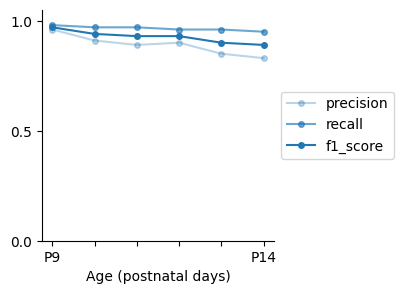

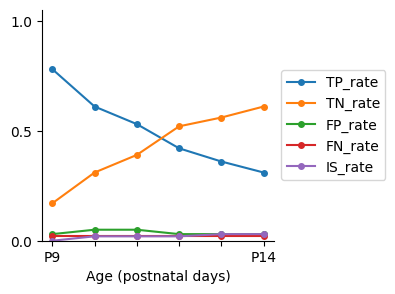

Aff_GCamp_AD
                   Unnamed: 0    P9   P10   P11   P12   P13   P14
0                     TP_rate  0.78  0.62  0.55  0.44  0.38  0.33
1                     TN_rate  0.17  0.31  0.39  0.52  0.56  0.61
2                     FP_rate  0.03  0.05  0.05  0.03  0.03  0.03
3                     FN_rate  0.02  0.02  0.02  0.02  0.02  0.02
4                     IS_rate  0.00  0.00  0.00  0.00  0.02  0.02
5  correctly_assign_link_rate  0.95  0.94  0.94  0.95  0.94  0.94
6  incorrect_assign_link_rate  0.05  0.06  0.06  0.05  0.06  0.06
7                   precision  0.96  0.93  0.92  0.93  0.89  0.88
8                      recall  0.98  0.98  0.97  0.97  0.96  0.95
9                    f1_score  0.97  0.95  0.95  0.95  0.92  0.91


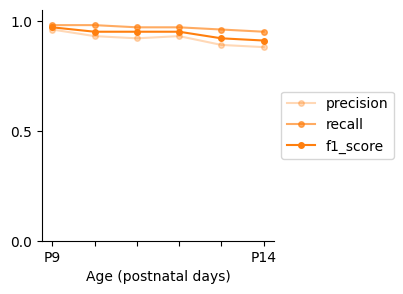

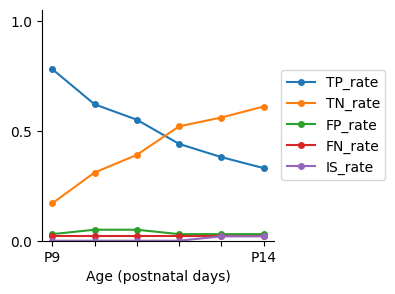

Rig_tdT_AD
                   Unnamed: 0    P9   P10   P11   P12   P13   P14
0                     TP_rate  0.78  0.59  0.06  0.06  0.06  0.05
1                     TN_rate  0.11  0.23  0.39  0.50  0.55  0.56
2                     FP_rate  0.09  0.12  0.05  0.05  0.05  0.08
3                     FN_rate  0.00  0.05  0.19  0.22  0.20  0.20
4                     IS_rate  0.02  0.00  0.31  0.17  0.14  0.11
5  correctly_assign_link_rate  0.89  0.83  0.45  0.56  0.61  0.61
6  incorrect_assign_link_rate  0.11  0.17  0.55  0.44  0.39  0.39
7                   precision  0.88  0.83  0.15  0.22  0.25  0.20
8                      recall  1.00  0.93  0.25  0.22  0.24  0.19
9                    f1_score  0.93  0.87  0.19  0.22  0.24  0.19


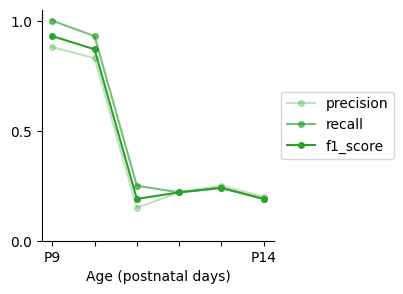

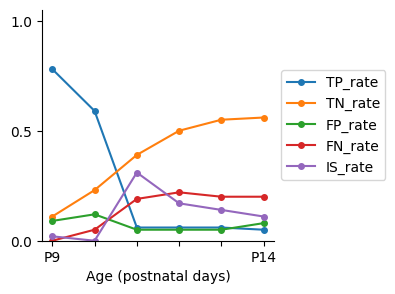

Aff_tdT_PW
                   Unnamed: 0    P9   P10   P11   P12   P13   P14
0                     TP_rate  0.78  0.64  0.48  0.05  0.05  0.02
1                     TN_rate  0.17  0.14  0.16  0.19  0.22  0.33
2                     FP_rate  0.03  0.22  0.28  0.36  0.38  0.31
3                     FN_rate  0.02  0.00  0.00  0.11  0.17  0.11
4                     IS_rate  0.00  0.00  0.08  0.30  0.19  0.23
5  correctly_assign_link_rate  0.95  0.78  0.64  0.23  0.27  0.34
6  incorrect_assign_link_rate  0.05  0.22  0.36  0.77  0.73  0.66
7                   precision  0.96  0.75  0.57  0.07  0.08  0.03
8                      recall  0.98  1.00  1.00  0.30  0.21  0.12
9                    f1_score  0.97  0.85  0.73  0.11  0.11  0.05


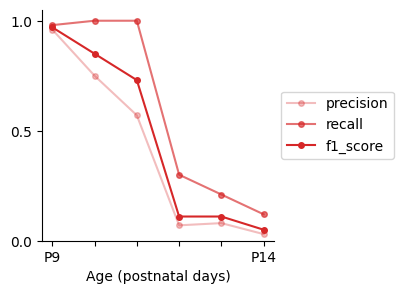

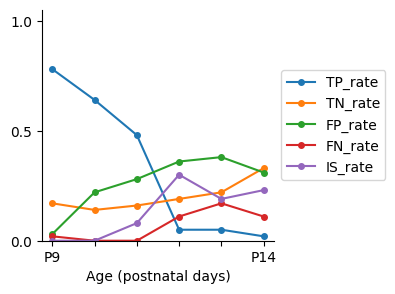

Aff_tdT_3days
                   Unnamed: 0    P9   P10   P11   P12   P13
0                     TP_rate  0.02  0.34  0.30  0.03  0.02
1                     TN_rate  0.38  0.38  0.36  0.31  0.34
2                     FP_rate  0.27  0.27  0.28  0.33  0.30
3                     FN_rate  0.16  0.00  0.05  0.17  0.22
4                     IS_rate  0.19  0.02  0.02  0.16  0.12
5  correctly_assign_link_rate  0.39  0.72  0.66  0.34  0.36
6  incorrect_assign_link_rate  0.61  0.28  0.34  0.66  0.64
7                   precision  0.03  0.55  0.50  0.06  0.04
8                      recall  0.09  1.00  0.86  0.15  0.07
9                    f1_score  0.05  0.71  0.63  0.09  0.05


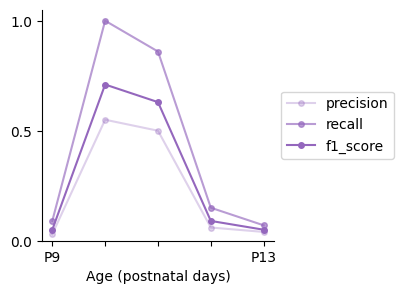

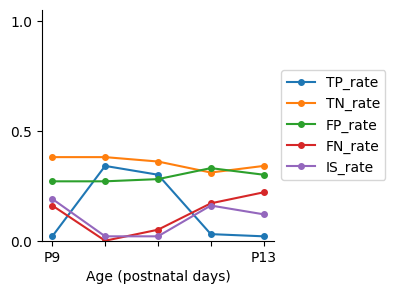

In [184]:
import numpy as np
from matplotlib.colors import to_rgba
import matplotlib.pyplot as plt

cmap_list = ['C0', 'C1', 'C2', 'C3', 'C4']
dfs_colors = [to_rgba(cmap) for cmap in cmap_list]

def generate_transparency_gradient(num_colors, idx):
    base_color = np.array(dfs_colors[idx])
    gradient = []
    for i in range(num_colors):
        alpha = 0.3 + 0.7 * (i / (num_colors - 1))   
        color_with_alpha = np.append(base_color[:3], alpha)  # Ajouter l'alpha à la couleur de base
        gradient.append(color_with_alpha)
    return gradient

for idx, (data, base_color) in enumerate(zip(dfs_dict, dfs_colors)):
    print(data)
    df = dfs_dict[data]
    print(df)
    f1_pcs_rcl = df[df[df.columns[0]].isin(['precision', 'recall', 'f1_score'])]
    rates = df[df[df.columns[0]].isin(['TP_rate', 'TN_rate', 'FP_rate','FN_rate','IS_rate'])]
    
    # Générer un dégradé de couleurs pour les tracés
    color_gradient = generate_transparency_gradient(len(f1_pcs_rcl), idx=idx)
    
    # Plot f1, precision, recall
    plt.figure(figsize=(3, 3))
    for (index, row), color in zip(f1_pcs_rcl.iterrows(), color_gradient):
        plt.plot(df.columns[1:], row[1:], marker='o', markersize=4, label=row[0], color=color)
        plt.ylim(0, 1.05)
        plt.yticks([0, 0.5, 1])
        plt.xlabel('Age (postnatal days)')
        ax = plt.gca()
        x_ticks = range(len(df.columns) - 1)
        ax.set_xticks(x_ticks)
        x_tick_labels = [''] * len(x_ticks)
        x_tick_labels[0] = df.columns[1]
        x_tick_labels[-1] = df.columns[-1]
        ax.set_xticklabels(x_tick_labels)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Placer la légende à droite
    plt.show()
    
    # Générer un dégradé de couleurs pour les tracés
    color_gradient = generate_transparency_gradient(len(rates), idx=idx)
    
    # Plot rates
    plt.figure(figsize=(3, 3))
    for (index, row), color in zip(rates.iterrows(), cmap_list_bis):
        plt.plot(df.columns[1:], row[1:], marker='o', markersize=4, label=row[0], color=color)
        plt.ylim(0, 1.05)
        plt.yticks([0, 0.5, 1])
        plt.xlabel('Age (postnatal days)')
        ax = plt.gca()
        x_ticks = range(len(df.columns) - 1)
        ax.set_xticks(x_ticks)
        x_tick_labels = [''] * len(x_ticks)
        x_tick_labels[0] = df.columns[1]
        x_tick_labels[-1] = df.columns[-1]
        ax.set_xticklabels(x_tick_labels)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Placer la légende à droite
    plt.show()

Aff_tdT_AD
  Unnamed: 0    P9   P10   P11   P12  P13   P14
9   f1_score  0.97  0.94  0.93  0.93  0.9  0.89
Aff_GCamp_AD
  Unnamed: 0    P9   P10   P11   P12   P13   P14
9   f1_score  0.97  0.95  0.95  0.95  0.92  0.91
Rig_tdT_AD
  Unnamed: 0    P9   P10   P11   P12   P13   P14
9   f1_score  0.93  0.87  0.19  0.22  0.24  0.19
Aff_tdT_PW
  Unnamed: 0    P9   P10   P11   P12   P13   P14
9   f1_score  0.97  0.85  0.73  0.11  0.11  0.05


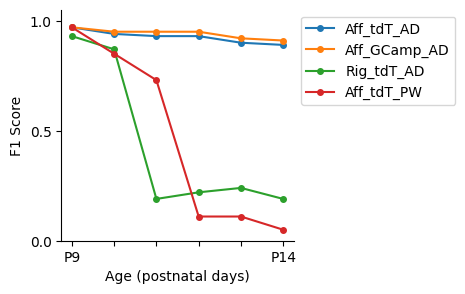

In [161]:

labels = ['Aff_Int_AD', 'Aff_Act_AD', 'Rig_Int_AD', 'Aff_Int_PW']

plt.figure(figsize=(3, 3))
for color, (data, df) in zip(cmap_list, dfs_dict.items()):
    f1_score_row = df[df[df.columns[0]] == 'f1_score']
    print(data)
    print(f1_score_row)
    for index, row in f1_score_row.iterrows():
        plt.plot(df.columns[1:], row[1:], marker='o', markersize=4, label=f'{data}', color=color)
        

plt.ylim(0, 1.05)
plt.yticks([0, 0.5, 1])
plt.ylabel('F1 Score')

ax = plt.gca()
x_ticks = range(len(df.columns) - 1)
ax.set_xticks(x_ticks)
x_tick_labels = [''] * len(x_ticks)
x_tick_labels[0] = df.columns[1]
x_tick_labels[-1] = df.columns[-1]
ax.set_xticklabels(x_tick_labels)


plt.xlabel('Age (postnatal days)')
plt.legend()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.show()

### All day evaluation

In [162]:

mtc_t2p_aff_chan0_all_track= pd.read_csv(os.path.join(parent_directory, 't2p_aff_chan0_all_', 'metrics_tracking_all_days.csv'),  names=['Metric', 'Value'], delimiter=';')
mtc_t2p_aff_chan1_all_track= pd.read_csv(os.path.join(parent_directory, 't2p_affine_chan1_all_', 'metrics_tracking_all_days.csv'),  names=['Metric', 'Value'], delimiter=';')
mtc_t2p_rig_chan1_all_track= pd.read_csv(os.path.join(parent_directory, 't2p_rigid_chan1_all_', 'metrics_tracking_all_days.csv'),  names=['Metric', 'Value'], delimiter=';')

print(mtc_t2p_aff_chan0_all_track)
print(mtc_t2p_aff_chan1_all_track)
print(mtc_t2p_rig_chan1_all_track)



      Metric  Value
0  Precision   0.88
1     Recall   0.95
2         F1   0.91
      Metric  Value
0  Precision   0.83
1     Recall   0.95
2         F1   0.89
      Metric  Value
0  Precision   0.20
1     Recall   0.19
2         F1   0.19


[0.83, 0.88, 0.2]
[0.95, 0.95, 0.19]
[0.89, 0.91, 0.19]


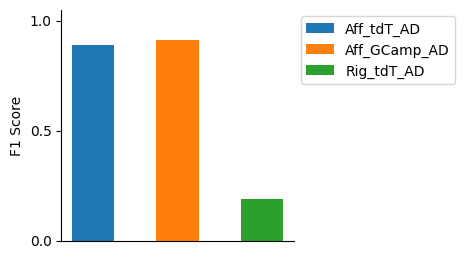

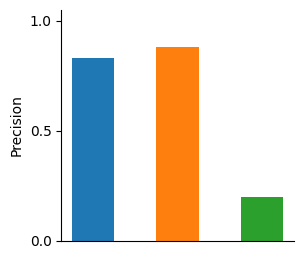

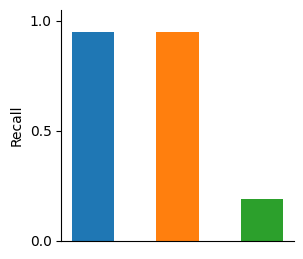

In [163]:
all_precision = []
all_f1 = []
all_recall = []

for data in [mtc_t2p_aff_chan1_all_track, mtc_t2p_aff_chan0_all_track, mtc_t2p_rig_chan1_all_track]:
    precision = data.loc[data['Metric'] == 'Precision', 'Value'].values[0]
    recall = data.loc[data['Metric'] == 'Recall', 'Value'].values[0]
    f1 = data.loc[data['Metric'] == 'F1', 'Value'].values[0]
    all_precision.append(precision)
    all_recall.append(recall)
    all_f1.append(f1)

print(all_precision)
print(all_recall)
print(all_f1)

labels = ['Aff_tdT_AD', 'Aff_GCamp_AD', 'Rig_tdT_AD']


# Création du barplot pour les valeurs de F1 avec légende
plt.figure(figsize=(3, 3))
for i, (label, f1) in enumerate(zip(labels, all_f1)):
    plt.bar(i, f1, color=['C0', 'C1', 'C2'][i], width=0.5, label=label)
plt.ylabel('F1 Score')
plt.ylim(0, 1.05)
plt.yticks([0, 0.5, 1])
plt.xticks(ticks=range(len(labels)), labels=[''] * len(labels))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', which='both', bottom=False, top=False)
plt.legend()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Création du barplot pour les valeurs de précision avec légende
plt.figure(figsize=(3, 3))
for i, (label, precision) in enumerate(zip(labels, all_precision)):
    plt.bar(i, precision, color=['C0', 'C1', 'C2'][i], width=0.5, label=label)
plt.ylabel('Precision')
plt.ylim(0, 1.05)
plt.yticks([0, 0.5, 1])
plt.xticks(ticks=range(len(labels)), labels=[''] * len(labels))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', which='both', bottom=False, top=False)
#plt.legend()
plt.show()

# Création du barplot pour les valeurs de rappel avec légende
plt.figure(figsize=(3, 3))
for i, (label, recall) in enumerate(zip(labels, all_recall)):
    plt.bar(i, recall, color=['C0', 'C1', 'C2'][i], width=0.5, label=label)
plt.ylabel('Recall')
plt.ylim(0, 1.05)
plt.yticks([0, 0.5, 1])
plt.xticks(ticks=range(len(labels)), labels=[''] * len(labels))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', which='both', bottom=False, top=False)
#plt.legend()
plt.show()

